In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import scipy as sp
import seaborn as sns
from scipy import stats

sns.set_theme("talk")
sns.set_style("darkgrid")

%matplotlib inline
%config Inline.figure_format = 'retina'

In [2]:
df = pd.read_csv("../results/ige_ege_jump.csv")
df["adaptation"] = np.nan
df["total error"] = np.nan
df.columns

Index(['si', 'SN', 'id', 'tester', 'TN', 'move_cycle', 'hX', 'hY', 'rot_hX',
       'rot_hY', 'rotation', 'tgt_jump', 'hand_max_dist', 'radvelmax', 'tgtX',
       'tgtY', 'rot_hand_theta', 'theta_maxradv', 'raw_ep_hand_ang', 'tgt_ang',
       'tgt_dist', 'fbi', 'MT', 'RT', 'ST', 'adaptation', 'total error'],
      dtype='object')

In [3]:
# Find outliers and remove based on hard threshold
outlier_idx = np.where(np.abs(df.theta_maxradv) >= 45)
outlier_idx = np.asarray(outlier_idx).flatten()
print(f'Total number of outliers: ', len(outlier_idx))
cols = ["rotation", "rot_hand_theta", "theta_maxradv", "raw_ep_hand_ang", "MT", "RT"]
df.loc[outlier_idx, cols] = np.nan
# df.loc[outlier_idx, :] = np.nan

Total number of outliers:  0


In [4]:
# # For regressing adaptation over total error at each level of ege:
# # 1) Split data into groups defined by ege;
# # 2) Bin data for each perturbation level into quintiles
# df_adapt["bin_vis"] = df_adapt.groupby("ege")["total_err_vis"].transform(lambda x: pd.qcut(x, 5, labels=[1, 2, 3, 4, 5]))
# df_adapt["bin_ege"] = df_adapt.groupby("ege")["total_err_ege"].transform(lambda x: pd.qcut(x, 5, labels=[1, 2, 3, 4, 5]))

# # Create data frames of binned data
# df_bin_vis = df_adapt.groupby(["ege", "bin_vis"])[["total_err_vis", "adapt_vis"]].mean()
# df_bin_vis.reset_index(inplace=True) # flatten data frame for easier indexing

# df_bin_ege = df_adapt.groupby(["ege", "bin_ege"])[["total_err_ege", "adapt_ege"]].mean()
# df_bin_ege.reset_index(inplace=True)

Adaptation to ege-vmr has slope of -0.698964589795953, p-val of 9.273930113521216e-41.
Adaptation to ige on rotation trials has slope of 0.00952833298902458, p-val of 0.9093161688856851.
Adaptation to ege-target jump has slope of 0.0893384536169598, p-val of 0.06800405117191832.
Adaptation to ige on target jump has slope of -0.13088463323461458, p-val of 0.08315774921893648.
Adaptation to ege-vmr has slope of -0.7833214569261302, p-val of 1.169928745559916e-41.
Adaptation to ige on rotation trials has slope of 0.05298030147859563, p-val of 0.5298824009145775.
Adaptation to ege-target jump has slope of -0.022550387314903317, p-val of 0.6798691652674578.
Adaptation to ige on target jump has slope of 0.13433375860763594, p-val of 0.05000597042208215.


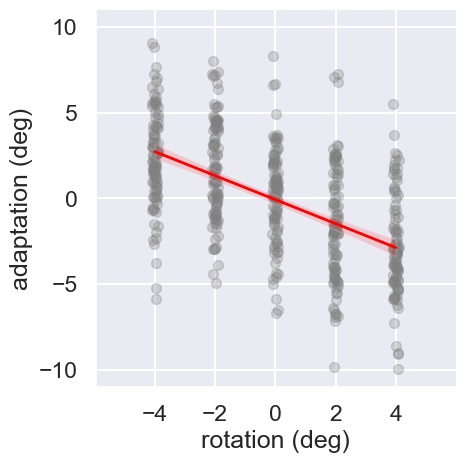

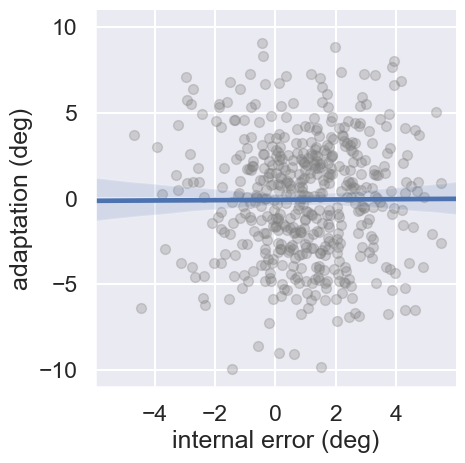

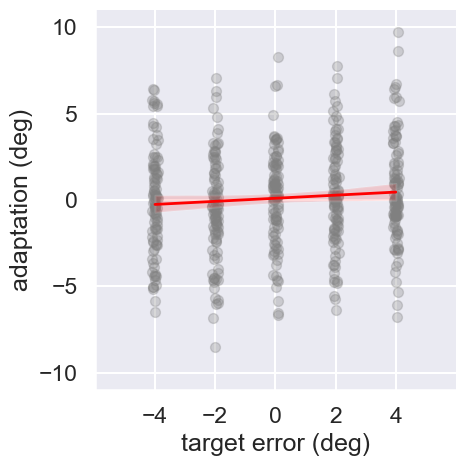

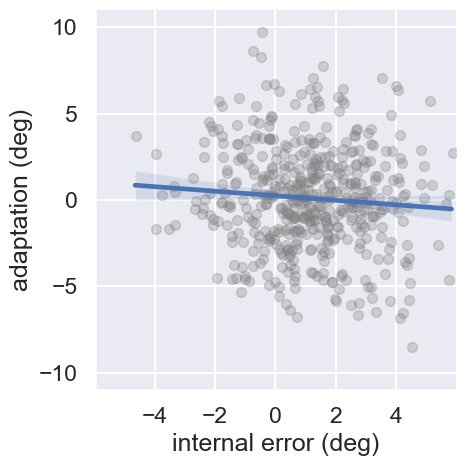

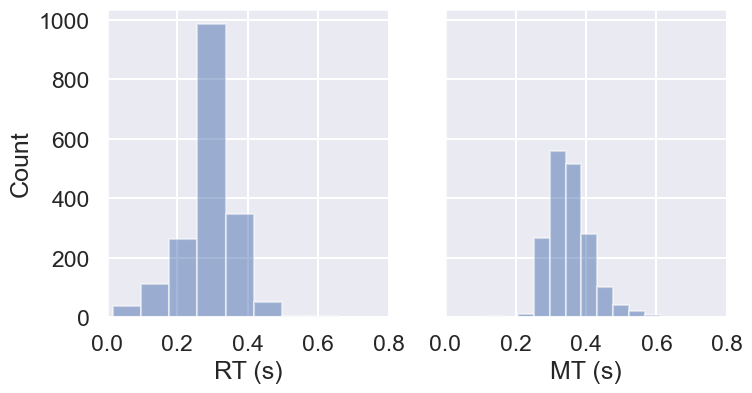

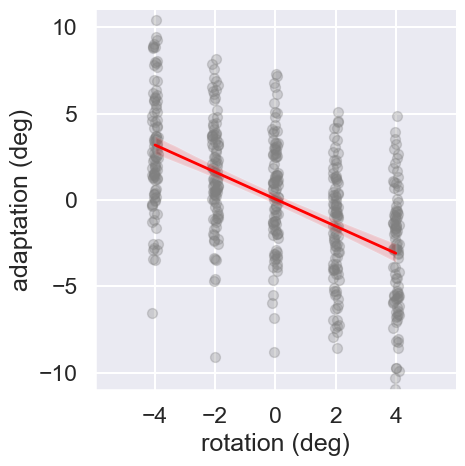

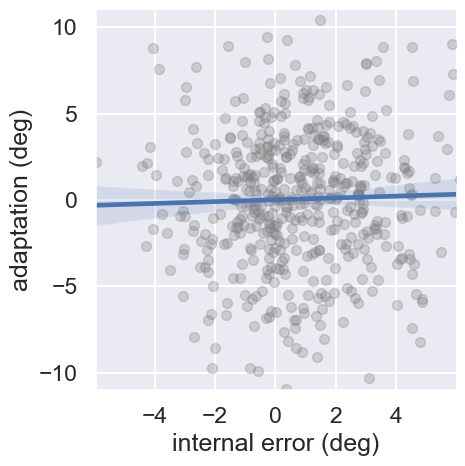

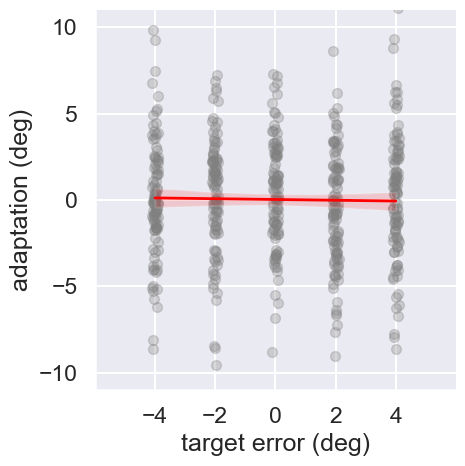

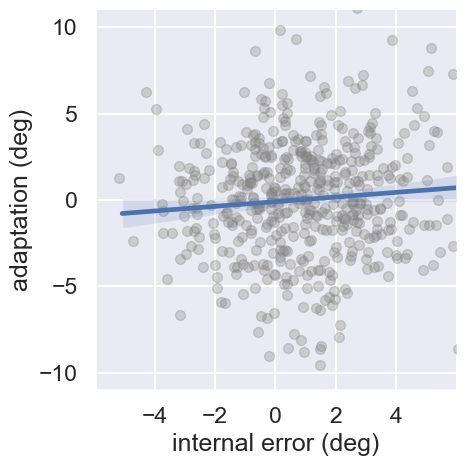

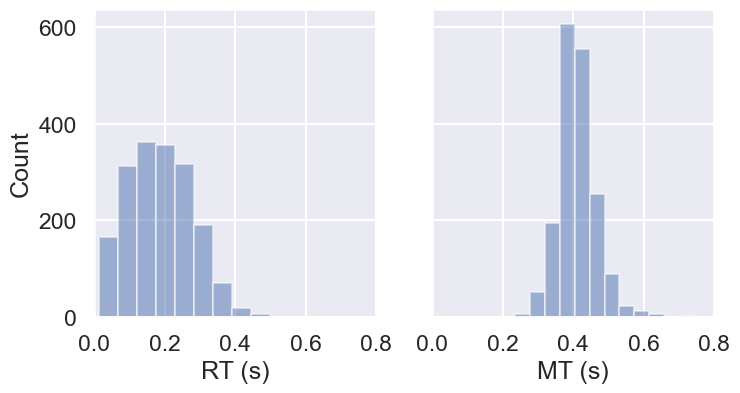

In [5]:
for s in df["id"].unique():
    # Create subject-specific data frame
    subj = df[df["id"] == s].reset_index()
    
    # Create truncated data frame without baseline trials
    training_start = 70
    pert_idx = np.arange(training_start, subj["TN"].max(), 2)
    subj_train = subj.iloc[training_start - 1:, :]
    
    # Loop through trials to get adaptation index
    for i in np.arange(training_start, subj["TN"].max(), 2):
        subj_train.loc[i, "adaptation"] = subj_train.loc[i+1, "theta_maxradv"] - subj_train.loc[i-1, "theta_maxradv"] 
        subj_train.loc[i, "total error"] = subj_train.loc[i, "theta_maxradv"] + subj_train.loc[i, "rotation"]
    
    subj_adapt = subj_train.loc[pert_idx, :].reset_index()
    subj_adapt["tgt_error"] = subj_adapt["tgt_jump"] * -1
    
    vmr = subj_adapt.loc[subj_adapt["tgt_jump"] == 0, :]  # Includes 0d rotation
    mask_jump = (subj_adapt["tgt_jump"] != 0) | ((subj_adapt["tgt_jump"] == 0) & (subj_adapt["rotation"] == 0))
    jump = subj_adapt[mask_jump]
    
    # Plot data for adapt vs vmr-ege
    g = sns.lmplot(data=vmr, x="rotation", y="adaptation", x_jitter=0.1, 
               scatter_kws=dict(alpha=0.3, color='gray', s=50), 
               line_kws=dict(linewidth=2, color='red'), ci=95)
    g.set(ylim=(-11, 11), xlim=(-6, 6), xticks=[-4, -2, 0, 2, 4], alpha=0.1, 
      xlabel="rotation (deg)", ylabel="adaptation (deg)")
    # g.savefig("adapt-vmr-ege.png")
    
    # Plot data for adapt vs ige
    g = sns.lmplot(data=vmr, x="theta_maxradv", y="adaptation", x_jitter=0.1, 
               scatter_kws=dict(alpha=0.3, color='gray', s=50), ci=95)
    g.set(ylim=(-11, 11), xlim=(-6, 6), xticks=[-4, -2, 0, 2, 4], alpha=0.1, 
      xlabel="internal error (deg)", ylabel="adaptation (deg)");
    # g.savefig("adapt-vmr-ige.png")

    # Plot data for adapt vs tgt_jump-ege
    g = sns.lmplot(data=jump, x="tgt_error", y="adaptation", x_jitter=0.1, 
                   scatter_kws=dict(alpha=0.3, color='gray', s=50), 
                   line_kws=dict(linewidth=2, color='red'), ci=95)
    g.set(ylim=(-11, 11), xlim=(-6, 6), xticks=[-4, -2, 0, 2, 4], alpha=0.1, 
          xlabel="target error (deg)", ylabel="adaptation (deg)");
    # g.savefig("adapt-target-jump-ege.png")

    # Plot data for adapt vs ige
    g = sns.lmplot(data=jump, x="theta_maxradv", y="adaptation", x_jitter=0.1, 
                   scatter_kws=dict(alpha=0.3, color='gray', s=50))
    g.set(ylim=(-11, 11), xlim=(-6, 6), xticks=[-4, -2, 0, 2, 4], alpha=0.1, 
          xlabel="internal error (deg)", ylabel="adaptation (deg)");
    # g.savefig("adapt-target-jump-ige.png")

    # Plot RTs and MTs
    fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
    ax[0].hist(subj_train["RT"], alpha=0.5, bins=12)
    ax[0].set(xlabel="RT (s)", ylabel="Count", xlim=[0, 0.8])
    ax[1].hist(subj_train["MT"], alpha=0.5, bins=12)
    ax[1].set(xlabel="MT (s)", xlim=[0, 0.8])

    # Print out statistics
    slope, intercept, r_value, p_value, std_err = stats.linregress(vmr["rotation"], vmr["adaptation"])
    print(f"Adaptation to ege-vmr has slope of {slope}, p-val of {p_value}.")

    slope, intercept, r_value, p_value, std_err = stats.linregress(vmr["theta_maxradv"], vmr["adaptation"])
    print(f"Adaptation to ige on rotation trials has slope of {slope}, p-val of {p_value}.")

    slope, intercept, r_value, p_value, std_err = stats.linregress(jump["tgt_error"], jump["adaptation"])
    print(f"Adaptation to ege-target jump has slope of {slope}, p-val of {p_value}.")

    slope, intercept, r_value, p_value, std_err = stats.linregress(jump["theta_maxradv"], jump["adaptation"])
    print(f"Adaptation to ige on target jump has slope of {slope}, p-val of {p_value}.")   